# Determining optimal number of topics using Coherence Score

Determining the optimal number of topics (num_topics) in LDA topic modeling is crucial for extracting meaningful insights. We can use coherence score to find the best number of topics. The coherence score measures the quality of topics by evaluating the semantic similarity of the top words in each topic. The higher the coherence score, the better the topics.

Note:
In topic modeling using Latent Dirichlet Allocation (LDA), the coherence score is a metric used to evaluate how semantically similar the words within a topic are to each other, essentially measuring how interpretable and meaningful a given topic is to humans; a higher coherence score indicates that the words within a topic are closely related and make sense together, while a lower score suggests a less coherent, unclear topic. 

Num Topics: 55, Coherence Score: 0.4178
Num Topics: 56, Coherence Score: 0.4177
Num Topics: 57, Coherence Score: 0.4155
Num Topics: 58, Coherence Score: 0.4159
Num Topics: 59, Coherence Score: 0.4077
Num Topics: 60, Coherence Score: 0.4044
Num Topics: 61, Coherence Score: 0.4143
Num Topics: 62, Coherence Score: 0.4047
Num Topics: 63, Coherence Score: 0.3903
Num Topics: 64, Coherence Score: 0.3898


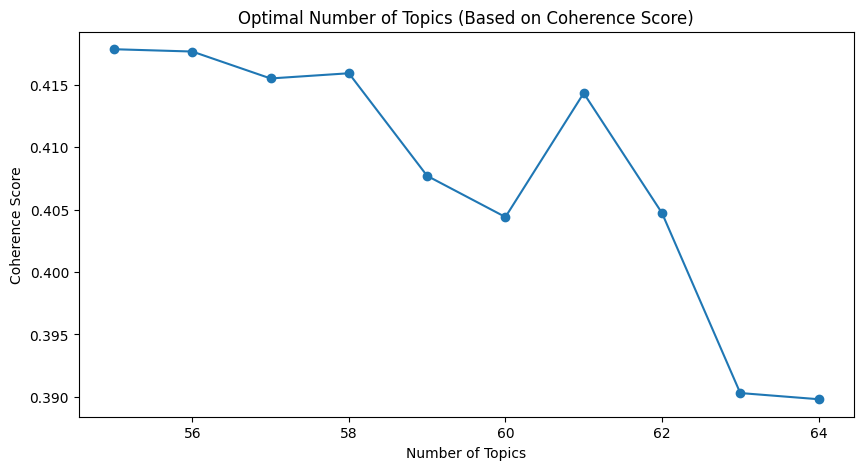

In [1]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Step 1: Load the dataset from the specified CSV file
df = pd.read_csv("../datasets/news_dataset_content_cleaned.csv")  

# Step 2: Convert the 'content_words' column to lists of tokenized words, if stored as strings
df['content_words'] = df['content_words'].apply(eval)

# Step 3: Construct the dictionary and corpus required for topic modeling
dictionary = corpora.Dictionary(df['content_words'])
dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=10000)  # Terms appearing in too few or too many documents are filtered out
corpus = [dictionary.doc2bow(text) for text in df['content_words']]

# Step 4: Specify the range of topic numbers to be evaluated
topic_range = range(55, 65) 
coherence_scores = []

# Step 5: Fit LDA models for each topic count and compute the corresponding coherence scores
for num_topics in topic_range:
    lda_model = gensim.models.LdaMulticore(
        corpus, num_topics=num_topics, id2word=dictionary, passes=5, workers=4, random_state=42
    )
    
    coherence_model = CoherenceModel(model=lda_model, texts=df['content_words'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

# Step 6: Visualize the coherence scores across different numbers of topics
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics (Based on Coherence Score)")
plt.show()

# WordCloud and Bar Chart as the Visualization of the Topic Modelling Result

LDA Coherence Score: 0.4262
LDA Perplexity: -9.2706
Topic 51: 0.084*"point" + 0.037*"choice" + 0.025*"room" + 0.022*"felt" + 0.021*"difference" + 0.021*"toward" + 0.020*"rest" + 0.019*"protection" + 0.016*"necessary" + 0.016*"carry"

Topic 37: 0.026*"level" + 0.026*"pay" + 0.024*"increase" + 0.020*"billion" + 0.018*"review" + 0.018*"spending" + 0.016*"total" + 0.015*"number" + 0.014*"fund" + 0.014*"debt"

Topic 23: 0.044*"percent" + 0.036*"center" + 0.034*"bank" + 0.030*"street" + 0.023*"followed" + 0.018*"digital" + 0.018*"limited" + 0.016*"german" + 0.015*"ran" + 0.015*"store"

Topic 39: 0.069*"think" + 0.057*"thing" + 0.049*"good" + 0.039*"really" + 0.033*"politics" + 0.031*"something" + 0.030*"important" + 0.024*"like" + 0.022*"feel" + 0.021*"people"

Topic 0: 0.052*"three" + 0.044*"set" + 0.034*"four" + 0.032*"later" + 0.031*"second" + 0.031*"last" + 0.031*"time" + 0.027*"two" + 0.027*"five" + 0.026*"hour"

Topic 9: 0.052*"july" + 0.041*"police" + 0.036*"man" + 0.028*"prosecutor" 

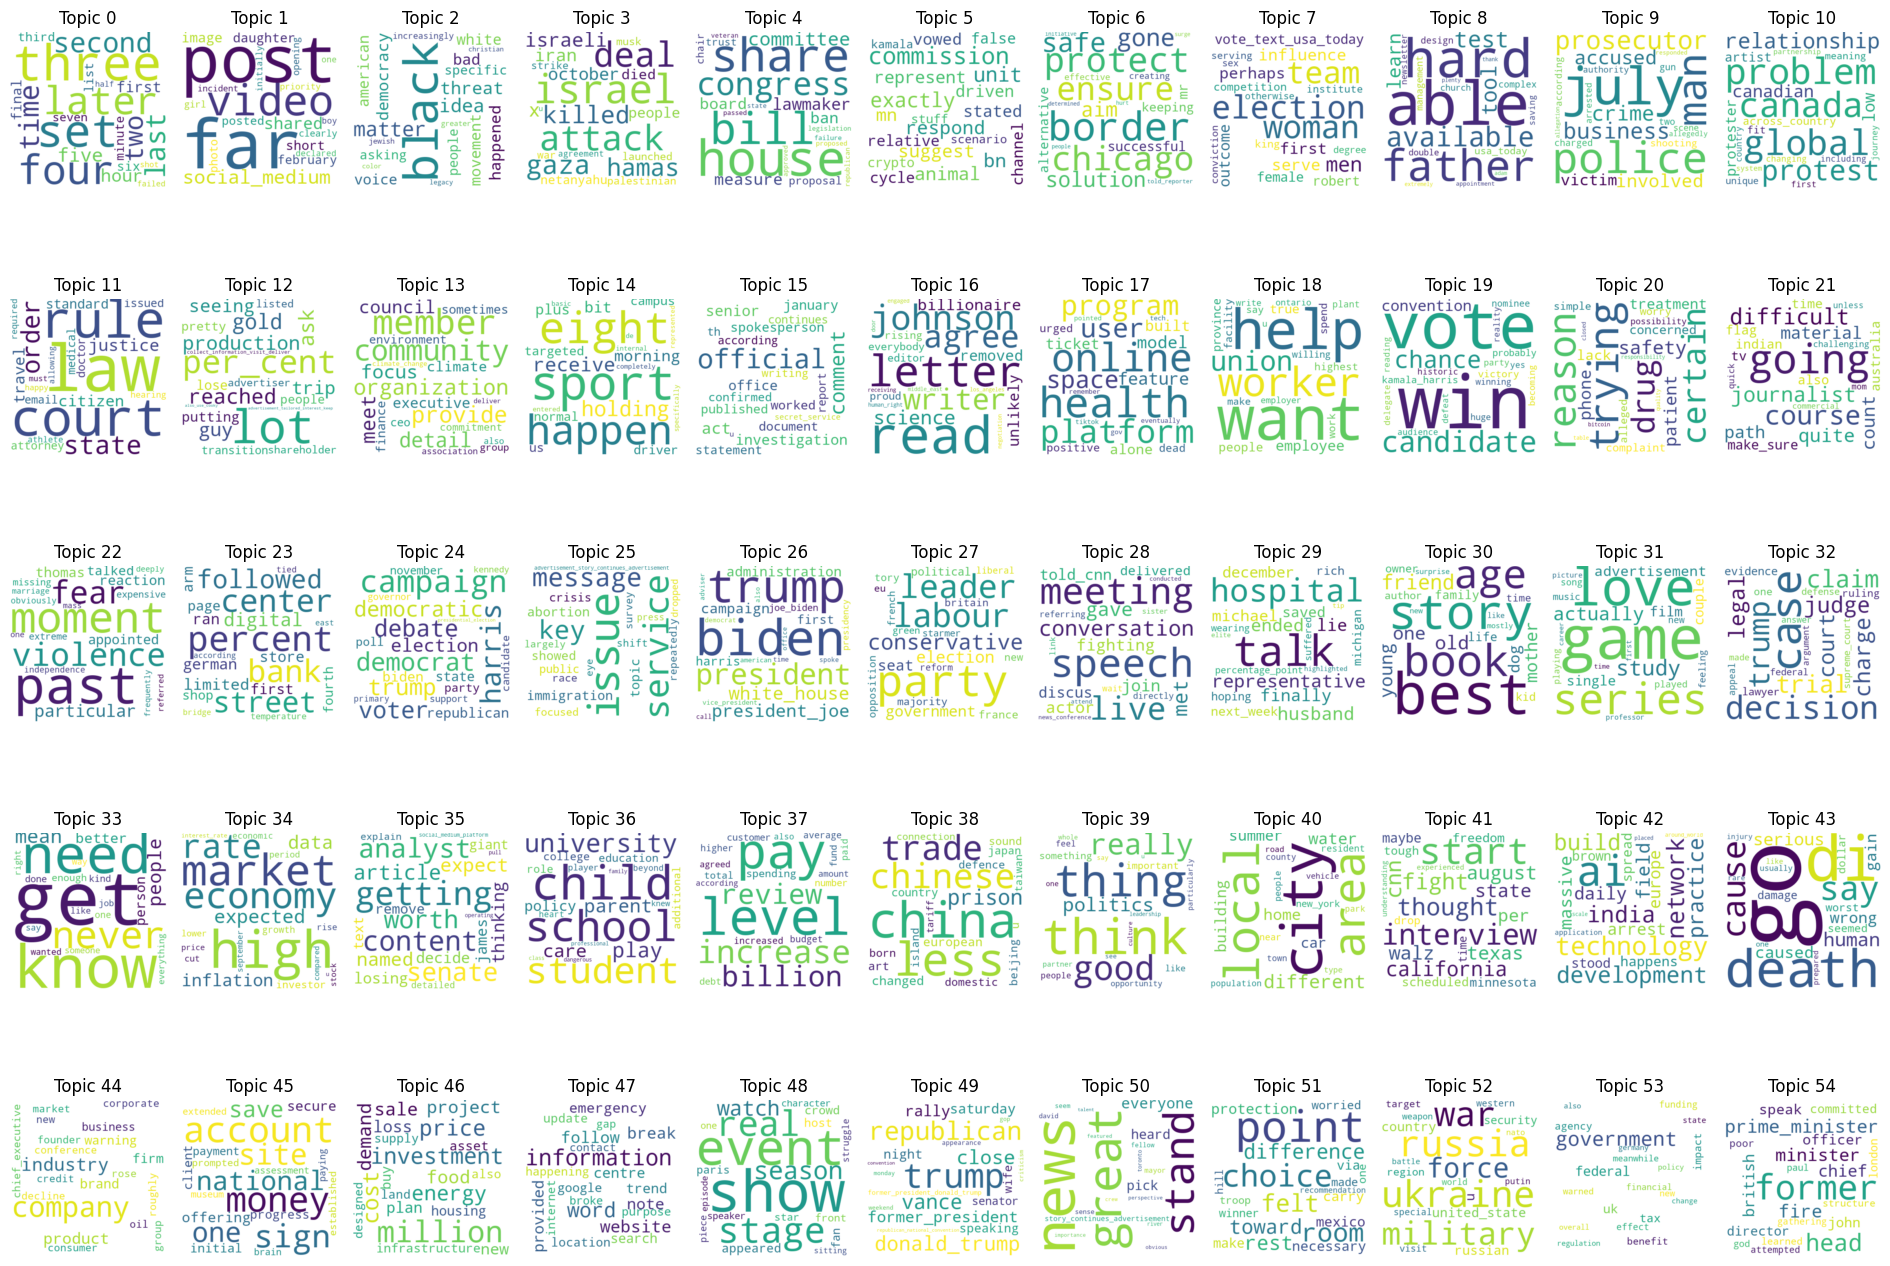

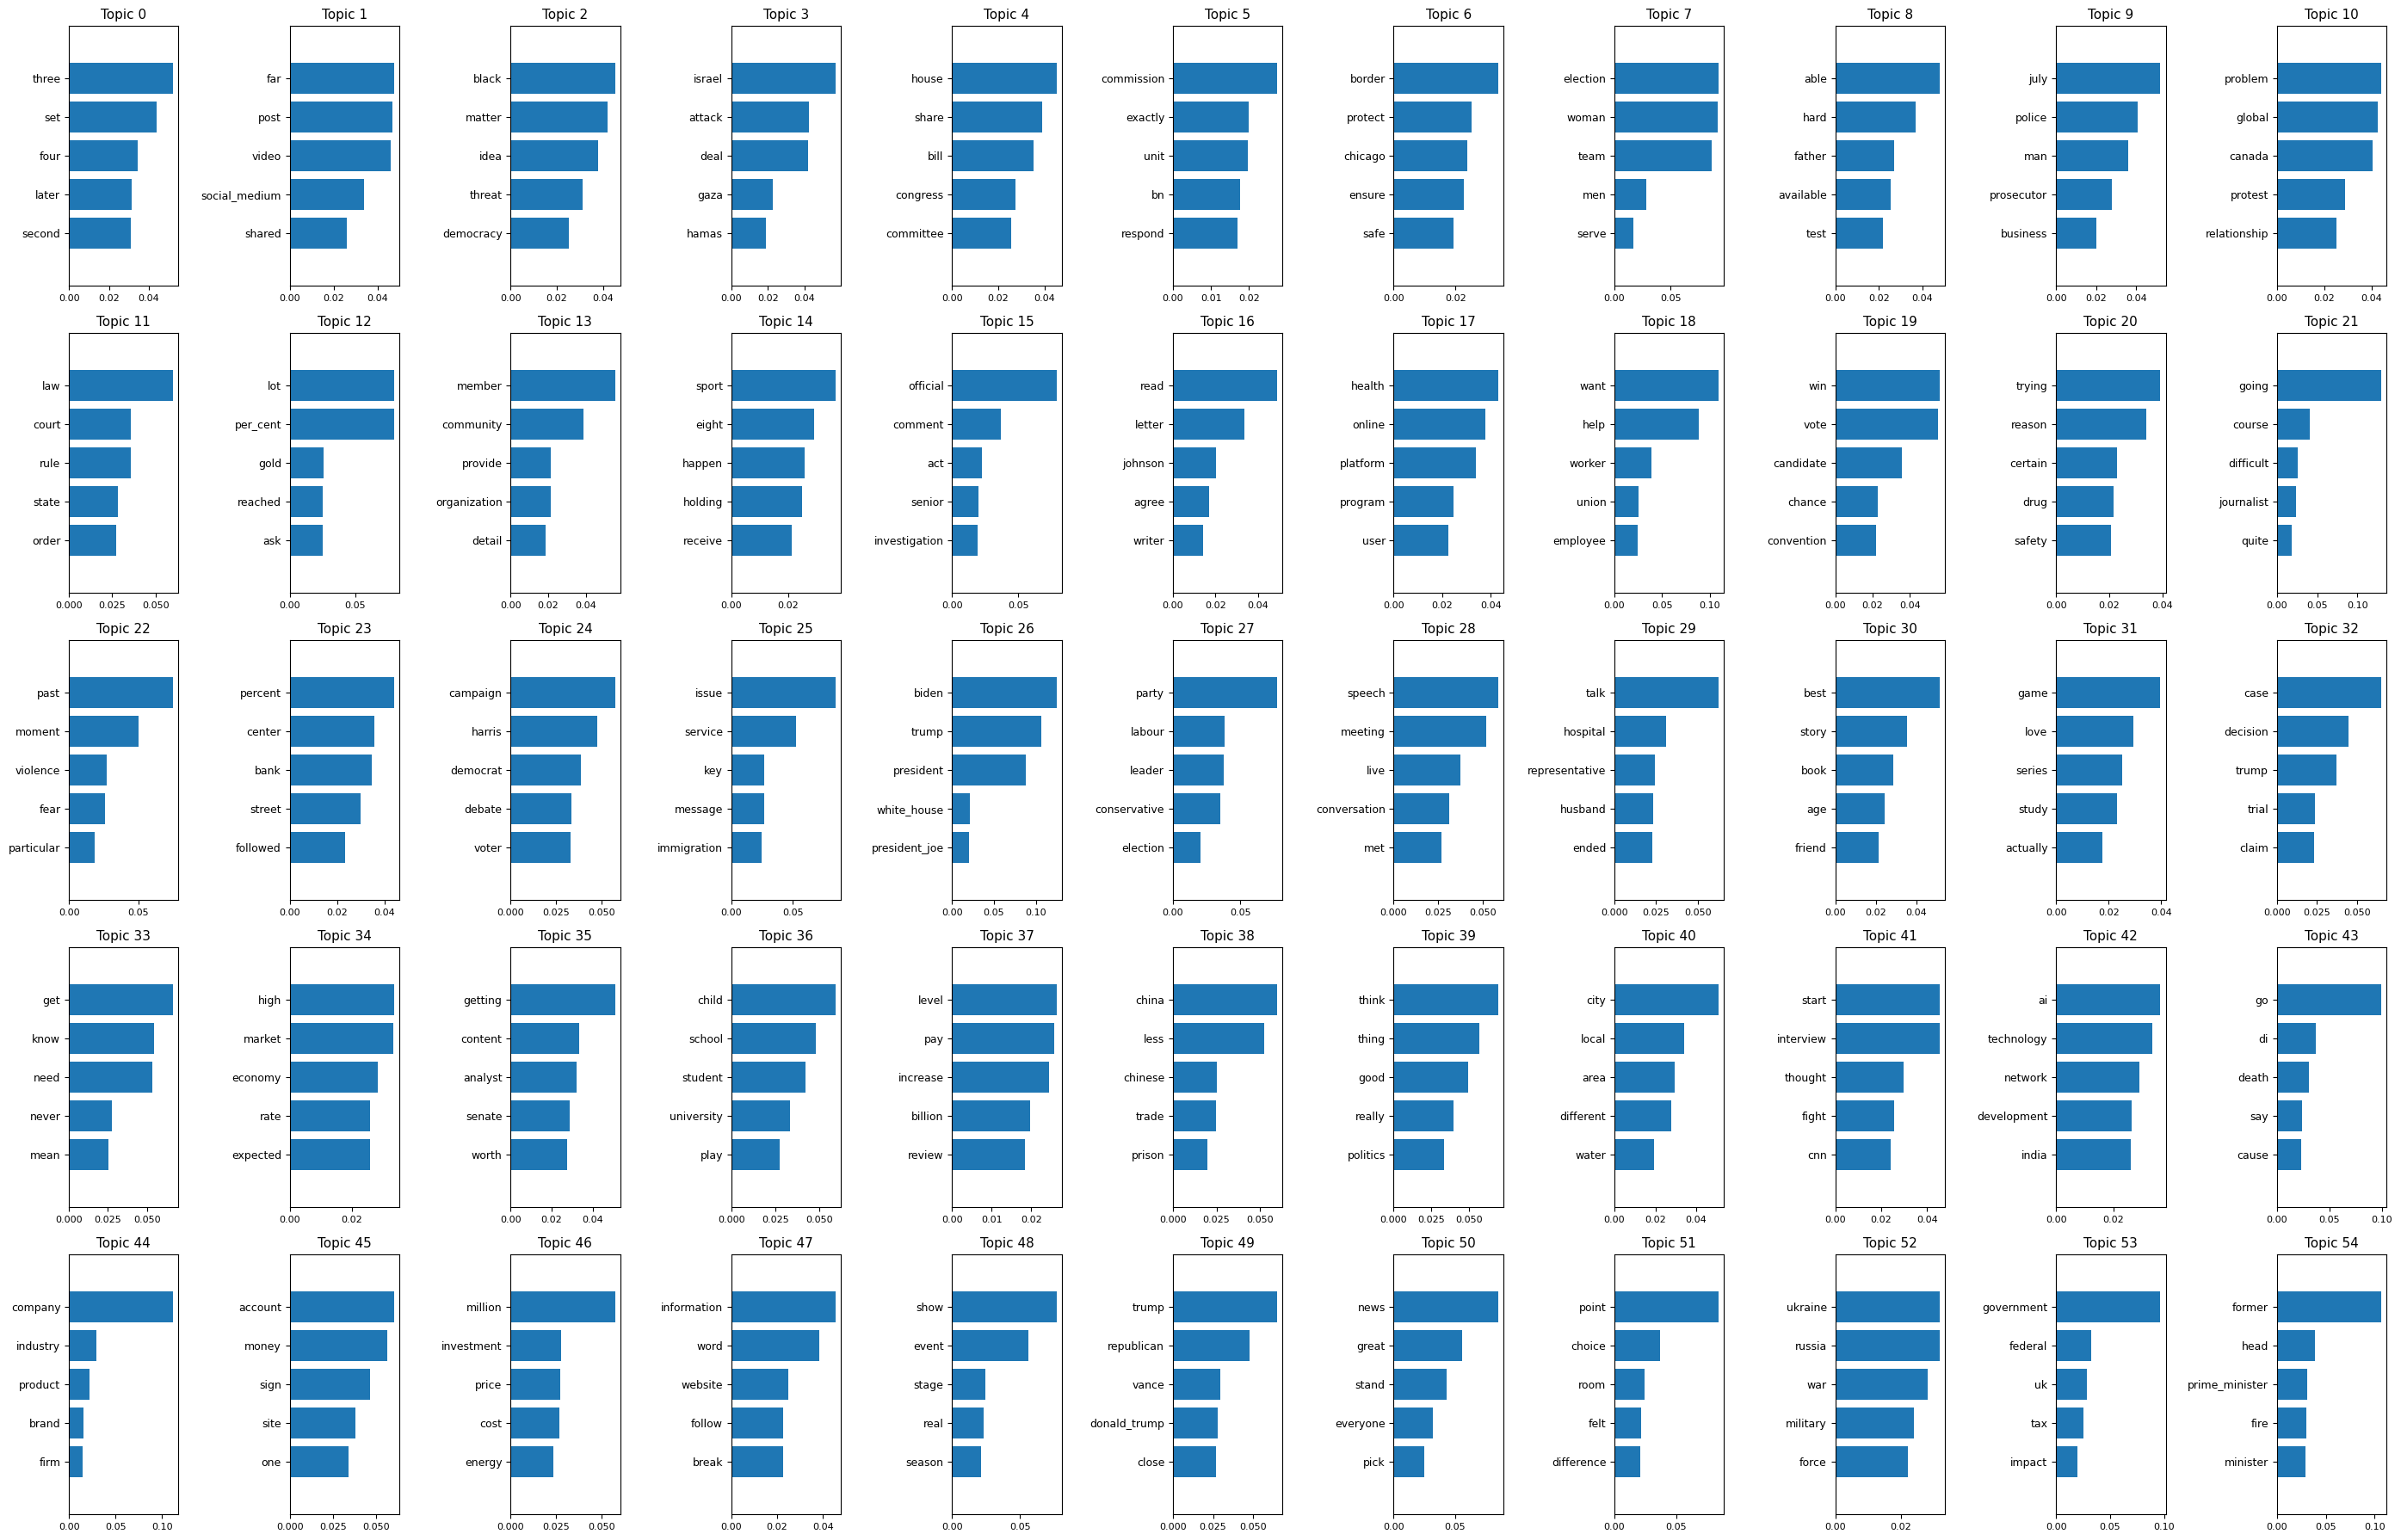

In [1]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

# Step 1: Load the dataset from the specified file path
df = pd.read_csv("../datasets/news_dataset_content_cleaned.csv")  

# Step 2: Convert the 'content_words' column into a list of tokenized words, if stored as string
df['content_words'] = df['content_words'].apply(eval)

# Step 3: Identify common bigrams and trigrams using elevated threshold parameters to reduce noise
bigram = Phrases(df['content_words'], min_count=10, threshold=30)
trigram = Phrases(bigram[df['content_words']], min_count=10, threshold=30)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Step 4: Apply the detected bigrams and trigrams to the tokenized content
df['content_words'] = df['content_words'].apply(lambda x: trigram_mod[bigram_mod[x]])

# Step 5: Filter out additional low-information words using a customized stopword list
custom_stopwords = set([
    "could", "should", "would", "may", "might", "said", "year", "just", "many", "even", 
    "still", "back",  "day", "week", "month", "use", "give", "take", "since", "much", 
    "got", "whether", "look", "always", "let", "yet", "asked", "across"
])
df['content_words'] = df['content_words'].apply(lambda x: [word for word in x if word not in custom_stopwords])

# Step 6: Create and filter a dictionary for LDA input (using training data only)
dictionary = corpora.Dictionary(df['content_words'])  # initial creation before split (will be overwritten below)
dictionary.filter_extremes(no_below=20, no_above=0.3, keep_n=10000)

# Step 7: Split the data into training and testing sets for proper evaluation
train_texts, test_texts = train_test_split(df['content_words'], test_size=0.2)

# Step 8: Create a dictionary and corpus from the training data; prepare test corpus using same dictionary
dictionary = corpora.Dictionary(train_texts)
dictionary.filter_extremes(no_below=20, no_above=0.3, keep_n=10000)

train_corpus = [dictionary.doc2bow(text) for text in train_texts]
test_corpus = [dictionary.doc2bow(text) for text in test_texts]

# Step 9: Train the LDA topic model using multicore processing on the training corpus
num_topics = 55
lda_model = LdaMulticore(
    corpus=train_corpus, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=10,
    workers=multiprocessing.cpu_count(), 
    random_state=42
)

# Step 10: Evaluate the model using coherence (semantic interpretability) and perplexity (generalization) on test set
coherence_model = CoherenceModel(model=lda_model, texts=test_texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
perplexity_score = lda_model.log_perplexity(test_corpus)

# Display the computed evaluation metrics
print(f"LDA Coherence Score: {coherence_score:.4f}")
print(f"LDA Perplexity: {perplexity_score:.4f}")

# Step 11: Display the top representative words for each generated topic
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}\n")

# Step 12: Generate visual representations of each topic using word clouds
fig, axes = plt.subplots(nrows=5, ncols=11, figsize=(19, 14))
axes = axes.flatten()

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, 20))
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(topic_words)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Topic {i}")

plt.tight_layout()
plt.show()

# Step 13: Save the trained LDA model and dictionary to disk for future use
lda_model.save("lda_model.model")
dictionary.save("lda_dictionary.dict")

# Step 14: Visualize the top five words in each topic using horizontal bar charts 
fig, axes = plt.subplots(nrows=5, ncols=11, figsize=(28, 18)) 
axes = axes.flatten()

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, 5))
    words = list(topic_words.keys())
    values = list(topic_words.values())

    axes[i].barh(words, values)
    axes[i].invert_yaxis()  # Highest value on top
    axes[i].set_title(f"Topic {i}", fontsize=11)
    axes[i].tick_params(axis='y', labelsize=9)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].margins(y=0.2)  # Adds vertical space around bars

# Fine-tuned spacing to prevent any overlap
plt.subplots_adjust(wspace=0.5, hspace=0.9)
plt.tight_layout()
plt.show()


# Assigning Dominant LDA Topic to Each Article
This section computes the dominant topic for each article by first running LDA on individual sentences, then aggregating the most frequent topic per article.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to compute topic distribution for each document using the trained LDA model
def get_topic_distribution(lda_model, corpus):
    topic_distributions = []
    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        topic_vector = [prob for _, prob in topic_probs]
        topic_distributions.append(topic_vector)
    return np.array(topic_distributions)

# Compute the topic distribution matrix for all documents
full_corpus = train_corpus + test_corpus
topic_distributions = get_topic_distribution(lda_model, full_corpus)

# Assign dominant topic per sentence
df["dominant_topic_lda"] = topic_distributions.argmax(axis=1)

# Aggregate dominant topics per article (most frequent one)
article_topic = df.groupby("article_text")["dominant_topic_lda"].agg(lambda x: x.value_counts().idxmax()).reset_index()

# Get article-level metadata (e.g., outlet, labels)
article_meta = df.drop_duplicates(subset="article_text")[["article_text", "outlet", "nlp_label", "nlp-image_label"]]

# Merge metadata with dominant topic
df_articles = article_meta.merge(article_topic, on="article_text")

# Define human-readable topic labels based on your word cloud
topic_labels = {
    0: "Court Cases & Justice",
    1: "Police & Violence",
    2: "Social Media & Online Activity",
    3: "Israel-Gaza Conflict",
    4: "Congress & U.S. Politics",
    5: "Bills & Legislative Process",
    6: "Border & Immigration",
    7: "Elections & Voting",
    8: "Police & Gender Issues",
    9: "Family & Crime",
    10: "Global Politics & Diplomacy",
    11: "Court Rulings",
    12: "Riots & Protests",
    13: "Community & Local Government",
    14: "Sports & College Life",
    15: "Government & Regulations",
    16: "Health & Online Platforms",
    17: "Worker Rights & Labor",
    18: "Campaigns & Voting",
    19: "Winning & Candidacy",
    20: "Media & Opinions",
    21: "Journalism & Challenges",
    22: "Past Events & Crime",
    23: "Banks & Finance",
    24: "Campaign Messaging",
    25: "Service & Employment",
    26: "US Presidential Candidates",
    27: "UK Politics",
    28: "Meetings & Speeches",
    29: "Hospitals & Health Issues",
    30: "Age & Retirement",
    31: "Entertainment & Gaming",
    32: "Judiciary & Decisions",
    33: "Economic Conditions",
    34: "Stock Market & Analysts",
    35: "Online Content & SEO",
    36: "Universities & Students",
    37: "Pay & Economic Inequality",
    38: "Trade & China",
    39: "General Politics",
    40: "Urban Development",
    41: "Fighting & Protests",
    42: "AI & Technology",
    43: "Death & Crime",
    44: "Business News",
    45: "Finance & Accounts",
    46: "Climate & Environment",
    47: "Information & Leaks",
    48: "Health & Real Issues",
    49: "Trump & Republicans",
    50: "News & Media",
    51: "Standoff & Government",
    52: "Russia-Ukraine War",
    53: "Governance & Policy",
    54: "Staff & Website Issues"
}

# Map topic number to human-readable topic name
df_articles["lda_topic_name"] = df_articles["dominant_topic_lda"].map(topic_labels)

# Show the result (head only)
df_articles.head()

,article_text,outlet,nlp_label,nlp-image_label,dominant_topic_lda,lda_topic_name
0,Tij Iginla doesn't shy away from his famous la...,CBC.ca,Likely to be Bias,Likely to be Unbiased,32,Judiciary & Decisions
1,This week on The Sunday Magazine with host Piy...,CBC.ca,Likely to be Bias,Likely to be Unbiased,46,Climate & Environment
2,An Ontario Conservative MP's use of ChatGPT to...,CBC News,Likely to be Bias,Likely to be Bias,24,Campaign Messaging
3,"When it comes to the study of sports, a man's ...",CBC.ca,Likely to be Unbiased,Likely to be Unbiased,49,Trump & Republicans
4,"To wrap up the 48th season of Quirks & Quarks,...",CBC.ca,Likely to be Bias,Likely to be Unbiased,11,Court Rulings
